In [1]:
import pandas as pd
import numpy as np
import warnings
import pyspark

warnings.simplefilter('ignore')

raw_prices = pd.read_csv(r'C:\Users\andr6\Documents\LowVolatility\Raw_prices.csv')
negocios = pd.read_csv(r'C:\Users\andr6\Documents\LowVolatility\Negocios.csv')
financeiro = pd.read_csv(r'C:\Users\andr6\Documents\LowVolatility\Financeiro.csv')
ibov = pd.read_csv(r'C:\Users\andr6\Documents\LowVolatility\Ibov_data.csv')

In [2]:
raw_prices['Datas'] = pd.to_datetime(raw_prices['Datas'])

In [3]:
precos_corte = raw_prices[(raw_prices['Datas'] >= '2000-01-01') & (raw_prices['Datas'] <= '2020-12-31')]

In [4]:
long_data = precos_corte.melt(id_vars=['Datas'], var_name='Codigo', value_name='Preco')

In [5]:
long_data['Ano'] = long_data['Datas'].dt.year

In [6]:
grouped_data = long_data.groupby(['Codigo', 'Ano'])

In [7]:
long_data['Total_Dias_Negociacao'] = long_data.groupby(['Codigo', 'Ano'])['Datas'].transform('nunique')
long_data['Pregoes'] = long_data.groupby(['Codigo', 'Ano'])['Preco'].transform(lambda x: x.notna().sum())
long_data['Pregoes_Percentual'] = long_data['Pregoes'] / long_data['Total_Dias_Negociacao']


In [8]:
long_data = long_data[long_data['Pregoes_Percentual'] > 0.9]

In [9]:
long_data = long_data.reset_index(drop=True)

In [10]:
long_data['Preco'] = long_data['Preco'].fillna(method='ffill')
long_data['Retorno'] = long_data.groupby('Codigo')['Preco'].pct_change()
long_data['Risco'] = long_data.groupby(['Codigo', 'Ano'])['Retorno'].transform(
    lambda x: np.sqrt(len(x.dropna())) * np.nanstd(x, ddof=1)
)
long_data['Mean_Risco'] = long_data.groupby(['Codigo', 'Ano'])['Risco'].transform(lambda x: x.mean(skipna=True))

In [11]:
long_data['Retorno_positivos'] = long_data.groupby(['Codigo', 'Ano'])['Retorno'].transform(lambda x: (x > 0).sum())
long_data['Retorno_negativos'] = long_data.groupby(['Codigo', 'Ano'])['Retorno'].transform(lambda x: (x < 0).sum())
long_data['Perc_positivos'] = long_data['Retorno_positivos'] / (long_data['Retorno_positivos'] + long_data['Retorno_negativos'])
long_data['Perc_negativos'] = long_data['Retorno_negativos'] / (long_data['Retorno_positivos'] + long_data['Retorno_negativos'])
long_data['Retorno'] = long_data['Retorno'].fillna(0)
long_data['Retorno_Anual'] = long_data.groupby(['Codigo', 'Ano'])['Retorno'].transform(lambda x: np.prod(1 + x) - 1)
long_data['Retorno_acumulado'] = long_data.groupby('Codigo')['Retorno'].transform(lambda x: (1 + x).cumprod() - 1)
long_data['FIP'] = long_data['Perc_negativos'] - long_data['Perc_positivos']

In [12]:
dados_agregados = long_data.groupby(['Codigo', 'Ano']).agg({'Retorno_Anual':'first', 'Risco':'first', 'FIP':'first'}).reset_index()

In [13]:
dados_agregados['Decil_Retorno'] = dados_agregados.groupby('Ano')['Retorno_Anual'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
dados_agregados['Decil_Risco'] = dados_agregados.groupby('Ano')['Risco'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
dados_agregados['Decil_FIP'] = dados_agregados.groupby(['Codigo', 'Ano'])['FIP'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)

In [14]:
dados_agregados['Decil_Retorno'] = dados_agregados.groupby('Ano')['Retorno_Anual'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
dados_agregados['Decil_Risco'] = dados_agregados.groupby('Ano')['Risco'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)
dados_agregados['Decil_FIP'] = dados_agregados.groupby('Ano')['FIP'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1)


In [15]:
long_data = pd.merge(long_data, dados_agregados[['Codigo', 'Ano', 'Decil_Retorno', 'Decil_Risco', 'Decil_FIP']], on=['Codigo', 'Ano'], how='left')

In [16]:
long_data['Retorno_Medio'] = long_data.groupby(['Codigo', 'Ano'])['Retorno'].transform(lambda x: x.mean(skipna=True))

In [17]:
# long_data = long_data.groupby(['Codigo', 'Ano']).first().reset_index().drop(['Preco'], axis=1)

In [18]:
# long_data_2 = long_data.groupby(['Codigo', 'Ano']).first().reset_index().drop(['Preco'], axis=1)

In [19]:
negocios['Datas'] = pd.to_datetime(negocios['Datas'])
negocios = negocios[(negocios['Datas'] >= '2000-01-01') & (negocios['Datas'] <= '2020-12-31')]
negocios = negocios.melt(id_vars=['Datas'], var_name='Codigo', value_name='Negocios')
negocios['Ano'] = negocios['Datas'].dt.year
negocios['Media_Negocios_Acao'] = negocios.groupby(['Codigo', 'Ano'])['Negocios'].transform(lambda x: x.mean(skipna=True))
negocios['Dias_Negocios'] = negocios.groupby(['Codigo', 'Ano'])['Negocios'].transform(lambda x: x.notna().sum())
dias_por_ano = negocios.groupby('Ano')['Datas'].nunique().rename('Total_Dias_Negociacao')
negocios = negocios.merge(dias_por_ano, on='Ano', how='left')
negocios['Negocios_Percentual'] = negocios['Dias_Negocios'] / negocios['Total_Dias_Negociacao']

In [20]:
negocios = negocios[negocios['Negocios_Percentual'] > 0.9]

In [21]:
negocios['Media_Negocios'] = negocios.groupby('Ano')['Negocios'].transform(lambda x: x.mean(skipna=True))

In [22]:
negocios['Razao_Media_Negocios'] = negocios['Media_Negocios_Acao'] / negocios['Media_Negocios']

In [23]:
negocios

,Datas,Codigo,Negocios,Ano,Media_Negocios_Acao,Dias_Negocios,Total_Dias_Negociacao,Negocios_Percentual,Media_Negocios,Razao_Media_Negocios
40439,2008-01-01,ABCB4,NaN,2008,56.943775,249,262,0.950382,738.928937,0.077063
40440,2008-01-02,ABCB4,42.0,2008,56.943775,249,262,0.950382,738.928937,0.077063
40441,2008-01-03,ABCB4,10.0,2008,56.943775,249,262,0.950382,738.928937,0.077063
40442,2008-01-04,ABCB4,23.0,2008,56.943775,249,262,0.950382,738.928937,0.077063
40443,2008-01-07,ABCB4,18.0,2008,56.943775,249,262,0.950382,738.928937,0.077063
...,...,...,...,...,...,...,...,...,...,...
7550057,2020-12-25,YDUQ3,NaN,2020,17584.401606,249,262,0.950382,8966.006332,1.961230
7550058,2020-12-28,YDUQ3,7092.0,2020,17584.401606,249,262,0.950382,8966.006332,1.961230
7550059,2020-12-29,YDUQ3,14530.0,2020,17584.401606,249,262,0.950382,8966.006332,1.961230
7550060,2020-12-30,YDUQ3,10899.0,2020,17584.401606,249,262,0.950382,8966.006332,1.961230


In [24]:
negocios_2 = negocios.groupby(['Codigo', 'Ano']).first().reset_index().drop(['Negocios'], axis=1)

In [25]:
financeiro['Datas'] = pd.to_datetime(financeiro['Datas'])
financeiro = financeiro[(financeiro['Datas'] >= '2000-01-01') & (financeiro['Datas'] <= '2020-12-31')]


In [26]:
financeiro = financeiro.melt(id_vars=['Datas'], var_name='Codigo', value_name='Financeiro')

In [27]:
financeiro['Ano'] = financeiro['Datas'].dt.year

In [28]:
financeiro['Media_Financeiro_Ativo_Ano'] = financeiro.groupby(['Codigo', 'Ano'])['Financeiro'].transform(lambda x: x.mean(skipna=True))

In [29]:
financeiro['Financeiro_Dias'] = financeiro.groupby(['Codigo', 'Ano'])['Financeiro'].transform(lambda x: x.notna().sum())

In [30]:
financeiro['Total_Financeiro_Dias'] = financeiro.groupby(['Codigo', 'Ano'])['Datas'].transform(lambda x: x.nunique())

In [31]:
financeiro['Financeiro_Dias_Percentual'] = financeiro['Financeiro_Dias'] / financeiro['Total_Financeiro_Dias']

In [32]:
financeiro = financeiro[financeiro['Financeiro_Dias_Percentual'] > 0.9]

In [33]:
financeiro['Media_Financeiro_Ano'] = financeiro.groupby('Ano')['Financeiro'].transform(lambda x: x.mean(skipna=True))
financeiro['DP_Financeiro_Ano'] = financeiro.groupby('Ano')['Financeiro'].transform(lambda x: x.std(skipna=True))

In [34]:
financeiro['Razao_Financeiro'] = financeiro['Media_Financeiro_Ativo_Ano'] / financeiro['Media_Financeiro_Ano']

In [35]:
financeiro_2 = financeiro.groupby(['Codigo', 'Ano']).first().reset_index().drop('Financeiro', axis=1)

In [36]:
df = long_data.merge(negocios_2, on=['Codigo', 'Ano'], how='left')

In [37]:
df = df.merge(financeiro_2, on=['Codigo', 'Ano'], how='left')

In [38]:
df = df.drop(['Total_Dias_Negociacao_y', 'Datas_y', 'Datas'], axis=1).rename(columns={'Datas_x':'Datas', 'Total_Dias_Negociacao_x':'Total_Dias_Negociacao'})

In [39]:
ibov['Datas'] = pd.to_datetime(ibov['Datas'])
ibov = ibov[(ibov['Datas'] >= '2000-01-01') & (ibov['Datas'] <= '2020-12-31')]
ibov['Pontos'] = ibov['Pontos'].fillna(method='ffill')
ibov['Retorno'] = ibov['Pontos'].pct_change()


In [40]:
ibov['Retorno'] = ibov['Retorno'].fillna(0)

In [41]:
ibov['Ret_Acumulado_Carteira'] = (1 + ibov['Retorno']).cumprod() - 1

In [42]:
ibov['Ano'] = ibov['Datas'].dt.year

In [43]:
ibov = ibov.reset_index(drop=True)

In [44]:
df_filtrado = df[(df['Razao_Financeiro'] > 0.05) & (df['Razao_Media_Negocios'] > 0.01)]

In [45]:
lista_dfs = [grupo.reset_index(drop=True) for _, grupo in df_filtrado.groupby('Ano')]

In [46]:
lista_dfs

[           Datas Codigo       Preco   Ano  Total_Dias_Negociacao  Pregoes  \
 0     2000-01-03  GETI4    1.847720  2000                    260      243   
 1     2000-01-04  GETI4    1.802209  2000                    260      243   
 2     2000-01-05  GETI4    1.875026  2000                    260      243   
 3     2000-01-06  GETI4    1.811312  2000                    260      243   
 4     2000-01-07  GETI4    1.858642  2000                    260      243   
 ...          ...    ...         ...   ...                    ...      ...   
 24955 2000-12-25  VIVO4  507.222123  2000                    260      248   
 24956 2000-12-26  VIVO4  509.268421  2000                    260      248   
 24957 2000-12-27  VIVO4  532.544852  2000                    260      248   
 24958 2000-12-28  VIVO4  522.555586  2000                    260      248   
 24959 2000-12-29  VIVO4  522.555586  2000                    260      248   
 
        Pregoes_Percentual   Retorno     Risco  Mean_Risco  ..

In [47]:
Lista_Carteira_Mercado = []

for df in lista_dfs:
    agrupado = df.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_Anual': 'mean',
        'Decil_Retorno': 'mean',
        'Decil_Risco': 'mean',
        'Ano': 'mean'
    }).reset_index()
    Lista_Carteira_Mercado.append(agrupado)


In [48]:
lista_carteira_1 = []
lista_carteira_2 = []
lista_carteira_3 = []
lista_carteira_4 = []
lista_carteira_5 = []

for df in lista_dfs:
    # Para a Carteira 1
    filtrado_1 = df[df['Decil_Risco'] <= 1]
    agregado_1 = filtrado_1.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_Anual': 'mean',
        'Decil_Retorno': 'mean',
        'Decil_Risco': 'mean',
        'Ano': 'mean'
    }).reset_index()
    lista_carteira_1.append(agregado_1)

    # Para a Carteira 2
    filtrado_2 = df[(df['Decil_Risco'] <= 2) & (df['Decil_Risco'] > 1)]
    agregado_2 = filtrado_2.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_Anual': 'mean',
        'Decil_Retorno': 'mean',
        'Decil_Risco': 'mean',
        'Ano': 'mean'
    }).reset_index()
    lista_carteira_2.append(agregado_2)

    # Para a Carteira 3
    filtrado_3 = df[(df['Decil_Risco'] <= 3) & (df['Decil_Risco'] > 2)]
    agregado_3 = filtrado_3.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_Anual': 'mean',
        'Decil_Retorno': 'mean',
        'Decil_Risco': 'mean',
        'Ano': 'mean'
    }).reset_index()
    lista_carteira_3.append(agregado_3)

    # Para a Carteira 4
    filtrado_4 = df[(df['Decil_Risco'] <= 4) & (df['Decil_Risco'] > 3)]
    agregado_4 = filtrado_4.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_Anual': 'mean',
        'Decil_Retorno': 'mean',
        'Decil_Risco': 'mean',
        'Ano': 'mean'
    }).reset_index()
    lista_carteira_4.append(agregado_4)

    # Para a Carteira 5
    filtrado_5 = df[(df['Decil_Risco'] <= 5) & (df['Decil_Risco'] > 4)]
    agregado_5 = filtrado_5.groupby('Codigo').agg({
        'Risco': 'mean',
        'Retorno_Anual': 'mean',
        'Decil_Retorno': 'mean',
        'Decil_Risco': 'mean',
        'Ano': 'mean'
    }).reset_index()
    lista_carteira_5.append(agregado_5)


In [49]:
lista_carteira_1[0]

,Codigo,Risco,Retorno_Anual,Decil_Retorno,Decil_Risco,Ano
0,BBAS3,0.369741,-0.285487,3.0,1.0,2000.0
1,BDLL4,0.360847,0.015736,7.0,1.0,2000.0
2,BRKM5,0.395469,0.088635,8.0,1.0,2000.0
3,ELET3,0.392971,-0.127976,5.0,1.0,2000.0
4,ITSA4,0.365302,0.004337,7.0,1.0,2000.0
5,PCAR4,0.368936,0.091606,8.0,1.0,2000.0
6,PETR4,0.387445,-0.064319,6.0,1.0,2000.0
7,TBLE6,0.357627,0.400693,9.0,1.0,2000.0
8,TEBA5,0.373339,0.418961,9.0,1.0,2000.0
9,TMGR6,0.370583,0.412478,9.0,1.0,2000.0


In [50]:
lista_trade_neutro = []
pd.set_option('display.max_columns', 100)
for i in range(1, 21):  # Ajuste para iniciar de 1 até 20, correspondente ao código R
    df_filtrado = lista_dfs[i]['Codigo'].isin(Lista_Carteira_Mercado[i-1]['Codigo'])
    df_filtrado = lista_dfs[i][df_filtrado]

  
    df_agrupado = df_filtrado.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()

    # Cálculo do retorno acumulado
    df_agrupado['Ret_Acumulado_Carteira'] = (1 + df_agrupado['Retorno_Carteira']).cumprod() - 1

    lista_trade_neutro.append(df_agrupado)

In [51]:
lista_trade_neutro

[         Datas  Retorno_Carteira  Ret_Acumulado_Carteira
 0   2001-01-01          0.000000                0.000000
 1   2001-01-02          0.006526                0.006526
 2   2001-01-03          0.070187                0.077171
 3   2001-01-04          0.000998                0.078246
 4   2001-01-05         -0.007304                0.070370
 ..         ...               ...                     ...
 256 2001-12-25          0.000000               -0.015254
 257 2001-12-26          0.001099               -0.014172
 258 2001-12-27          0.023580                0.009073
 259 2001-12-28         -0.016883               -0.007963
 260 2001-12-31          0.000000               -0.007963
 
 [261 rows x 3 columns],
          Datas  Retorno_Carteira  Ret_Acumulado_Carteira
 0   2002-01-01          0.000000                0.000000
 1   2002-01-02          0.022090                0.022090
 2   2002-01-03          0.026963                0.049648
 3   2002-01-04          0.005734            

In [52]:
lista_trade_1 = []
lista_trade_2 = []
lista_trade_3 = []
lista_trade_4 = []
lista_trade_5 = []

for i in range(1, 21):
    df1 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_1[i-1]['Codigo'])]
    df1_grouped = df1.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df1_grouped['Ret_Acumulado_Carteira'] = (1 + df1_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_1.append(df1_grouped)
    
for i in range(1, 21):
    df2 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_2[i-1]['Codigo'])]
    df2_grouped = df2.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df2_grouped['Ret_Acumulado_Carteira'] = (1 + df2_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_2.append(df2_grouped)

for i in range(1, 21):
    df3 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_3[i-1]['Codigo'])]
    df3_grouped = df3.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df3_grouped['Ret_Acumulado_Carteira'] = (1 + df3_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_3.append(df3_grouped)
    
for i in range(1, 21):
    df4 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_4[i-1]['Codigo'])]
    df4_grouped = df4.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df4_grouped['Ret_Acumulado_Carteira'] = (1 + df4_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_4.append(df4_grouped)
    
for i in range(1, 21):
    df5 = lista_dfs[i].loc[lista_dfs[i]['Codigo'].isin(lista_carteira_5[i-1]['Codigo'])]
    df5_grouped = df5.groupby('Datas').agg(Retorno_Carteira=('Retorno', lambda x: x.mean(skipna=True))).reset_index()
    df5_grouped['Ret_Acumulado_Carteira'] = (1 + df5_grouped['Retorno_Carteira']).cumprod() - 1
    lista_trade_5.append(df5_grouped)

In [53]:
lista_trade_1

[         Datas  Retorno_Carteira  Ret_Acumulado_Carteira
 0   2001-01-01          0.000000                0.000000
 1   2001-01-02          0.005764                0.005764
 2   2001-01-03          0.054015                0.060091
 3   2001-01-04         -0.005349                0.054421
 4   2001-01-05         -0.009114                0.044811
 ..         ...               ...                     ...
 256 2001-12-25          0.000000               -0.000148
 257 2001-12-26          0.011445                0.011296
 258 2001-12-27          0.018977                0.030488
 259 2001-12-28          0.000236                0.030731
 260 2001-12-31          0.000000                0.030731
 
 [261 rows x 3 columns],
          Datas  Retorno_Carteira  Ret_Acumulado_Carteira
 0   2002-01-01          0.000000                0.000000
 1   2002-01-02         -0.001246               -0.001246
 2   2002-01-03          0.011709                0.010449
 3   2002-01-04         -0.001542            

In [54]:
lista_ibovespa = [grupo.reset_index(drop=True) for _, grupo in ibov.groupby('Ano')]

In [55]:
lista_ibovespa_2 = []
for i in range(21):
    df_ibov = lista_ibovespa[i].copy()
    df_ibov['Ret_Acumulado_Carteira'] = (1 + df_ibov['Retorno']).cumprod() - 1
    lista_ibovespa_2.append(df_ibov)

In [56]:
lista_ibovespa_2

[         Datas   Pontos   Retorno  Ret_Acumulado_Carteira   Ano
 0   2000-01-03  16930.0  0.000000                0.000000  2000
 1   2000-01-04  15851.0 -0.063733               -0.063733  2000
 2   2000-01-05  16245.0  0.024856               -0.040461  2000
 3   2000-01-06  16106.0 -0.008556               -0.048671  2000
 4   2000-01-07  16309.0  0.012604               -0.036680  2000
 ..         ...      ...       ...                     ...   ...
 255 2000-12-25  14652.0  0.000000               -0.134554  2000
 256 2000-12-26  14794.0  0.009692               -0.126167  2000
 257 2000-12-27  15186.0  0.026497               -0.103012  2000
 258 2000-12-28  15259.0  0.004807               -0.098701  2000
 259 2000-12-29  15259.0  0.000000               -0.098701  2000
 
 [260 rows x 5 columns],
          Datas   Pontos   Retorno  Ret_Acumulado_Carteira   Ano
 0   2001-01-01  15259.0  0.000000                0.000000  2001
 1   2001-01-02  15425.0  0.010879                0.010879  200

In [57]:
lista_trade_5

[         Datas  Retorno_Carteira  Ret_Acumulado_Carteira
 0   2001-01-01          0.000000                0.000000
 1   2001-01-02          0.033553                0.033553
 2   2001-01-03          0.052962                0.088292
 3   2001-01-04          0.001501                0.089925
 4   2001-01-05         -0.003548                0.086058
 ..         ...               ...                     ...
 256 2001-12-25          0.000000               -0.015176
 257 2001-12-26          0.003486               -0.011742
 258 2001-12-27          0.024608                0.012576
 259 2001-12-28         -0.011087                0.001350
 260 2001-12-31          0.000000                0.001350
 
 [261 rows x 3 columns],
          Datas  Retorno_Carteira  Ret_Acumulado_Carteira
 0   2002-01-01          0.000000                0.000000
 1   2002-01-02          0.029053                0.029053
 2   2002-01-03          0.043876                0.074204
 3   2002-01-04          0.002102            

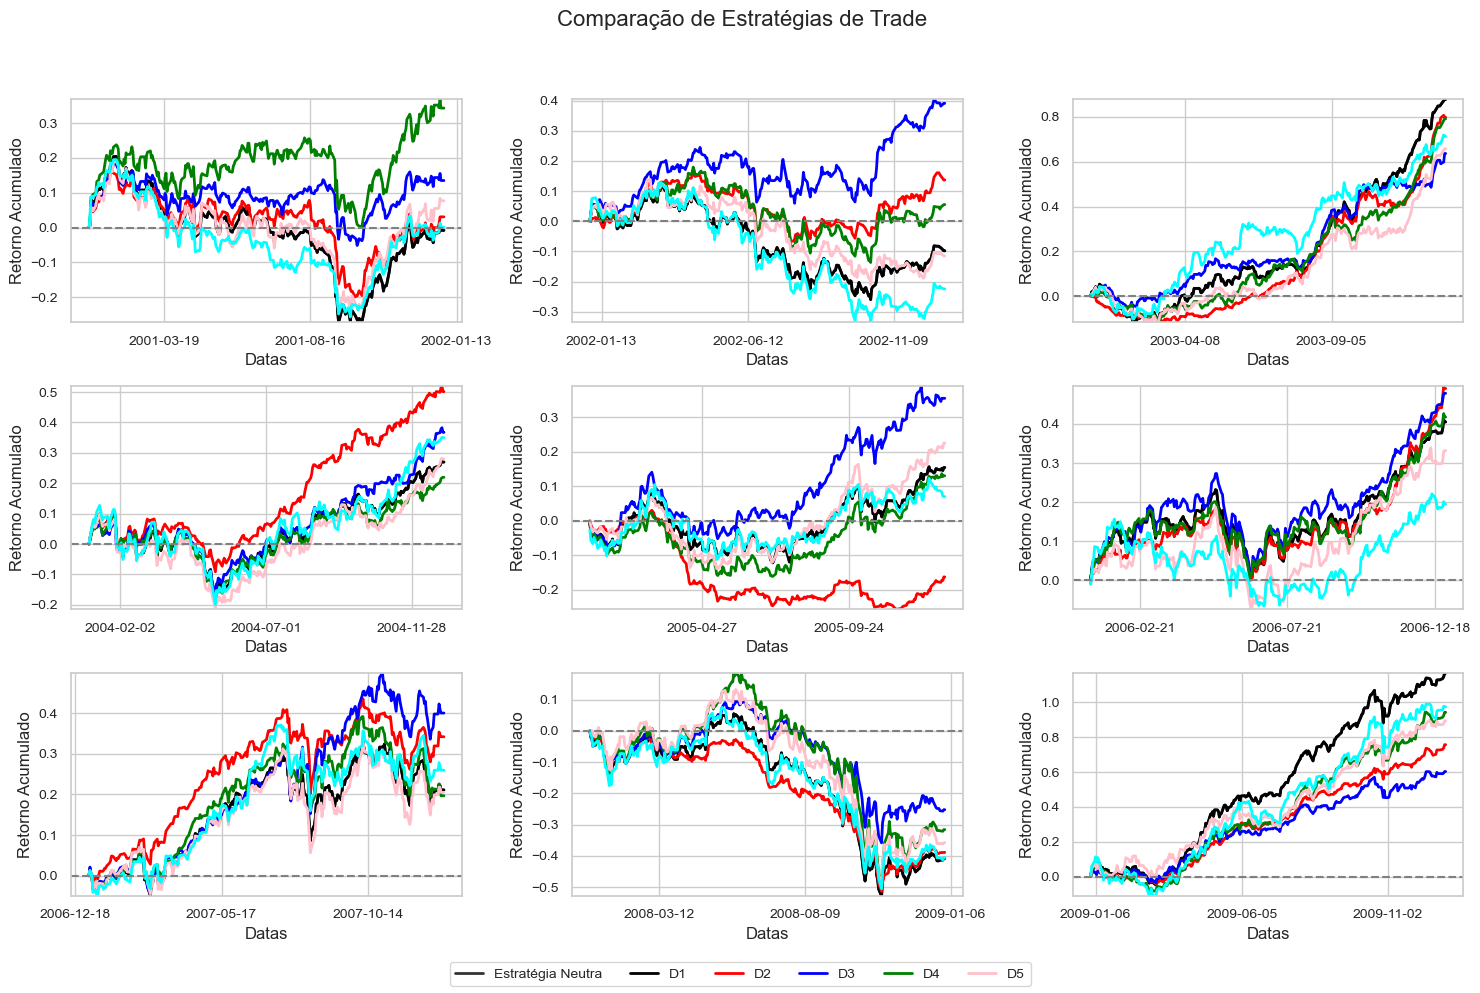

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

sns.set(style="whitegrid")

# Configurando o layout do gráfico
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(lista_trade_neutro):
        break
    ax.plot(lista_trade_neutro[i]['Datas'], lista_trade_neutro[i]['Ret_Acumulado_Carteira'], label='Estratégia Neutra', color='black', linewidth=2, alpha=0.8)
    ax.plot(lista_trade_neutro[i]['Datas'], lista_trade_neutro[i]['Ret_Acumulado_Carteira'], label='Estratégia Neutra', color='black', linewidth=2)
    ax.plot(lista_trade_1[i]['Datas'], lista_trade_1[i]['Ret_Acumulado_Carteira'], label='D1', color='red', linewidth=2)
    ax.plot(lista_trade_2[i]['Datas'], lista_trade_2[i]['Ret_Acumulado_Carteira'], label='D2', color='blue', linewidth=2)
    ax.plot(lista_trade_3[i]['Datas'], lista_trade_3[i]['Ret_Acumulado_Carteira'], label='D3', color='green', linewidth=2)
    ax.plot(lista_trade_4[i]['Datas'], lista_trade_4[i]['Ret_Acumulado_Carteira'], label='D4', color='pink', linewidth=2)
    ax.plot(lista_trade_5[i]['Datas'], lista_trade_5[i]['Ret_Acumulado_Carteira'], label='D5', color='cyan', linewidth=2)
    
    ax.set_xlabel('Datas', fontsize=12)
    ax.set_ylabel('Retorno Acumulado', fontsize=12)
    ax.axhline(y=0, color='grey', linestyle='--')
    
    y_min = min([min(dataset['Ret_Acumulado_Carteira']) for dataset in [lista_trade_neutro[i], lista_trade_1[i], lista_trade_2[i], lista_trade_3[i], lista_trade_4[i], lista_trade_5[i]]])  # Adicione todos os datasets
    y_max = max([max(dataset['Ret_Acumulado_Carteira']) for dataset in [lista_trade_neutro[i], lista_trade_1[i], lista_trade_2[i], lista_trade_3[i], lista_trade_4[i], lista_trade_5[i]]])  # Adicione todos os datasets
    ax.set_ylim([y_min, y_max])

    ax.xaxis.set_major_locator(MaxNLocator(3))
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.figlegend(['Estratégia Neutra', 'D1', 'D2', 'D3', 'D4', 'D5'], loc='lower center', ncol=6, labelspacing=0., fontsize=10)
plt.suptitle("Comparação de Estratégias de Trade", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [74]:
port_trade_neutro = pd.concat(lista_trade_neutro)
port_trade_neutro['Ret_Acumulado_Carteira'] = (1 + port_trade_neutro['Retorno_Carteira']).cumprod() - 1

port_trade_1 = pd.concat(lista_trade_1)
port_trade_1['Ret_Acumulado_Carteira'] = (1 + port_trade_1['Retorno_Carteira']).cumprod() - 1

port_trade_2 = pd.concat(lista_trade_2)
port_trade_2['Ret_Acumulado_Carteira'] = (1 + port_trade_2['Retorno_Carteira']).cumprod() - 1

port_trade_3 = pd.concat(lista_trade_3)
port_trade_3['Ret_Acumulado_Carteira'] = (1 + port_trade_3['Retorno_Carteira']).cumprod() - 1

port_trade_4 = pd.concat(lista_trade_4)
port_trade_4['Ret_Acumulado_Carteira'] = (1 + port_trade_4['Retorno_Carteira']).cumprod() - 1

port_trade_5 = pd.concat(lista_trade_5)
port_trade_5['Ret_Acumulado_Carteira'] = (1 + port_trade_5['Retorno_Carteira']).cumprod() - 1


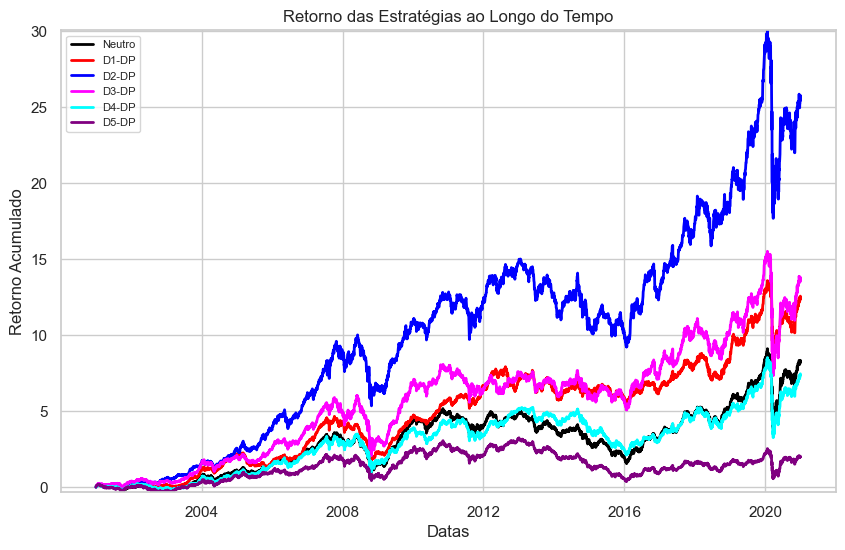

In [82]:
plt.figure(figsize=(10, 6))

# Plotando as linhas para cada conjunto de dados
plt.plot(port_trade_neutro['Datas'], port_trade_neutro['Ret_Acumulado_Carteira'], label='Neutro', color='black', linewidth=2)
plt.plot(port_trade_1['Datas'], port_trade_1['Ret_Acumulado_Carteira'], label='D1-DP', color='red', linewidth=2)
plt.plot(port_trade_2['Datas'], port_trade_2['Ret_Acumulado_Carteira'], label='D2-DP', color='blue', linewidth=2)
plt.plot(port_trade_3['Datas'], port_trade_3['Ret_Acumulado_Carteira'], label='D3-DP', color='magenta', linewidth=2)
plt.plot(port_trade_4['Datas'], port_trade_4['Ret_Acumulado_Carteira'], label='D4-DP', color='cyan', linewidth=2)
plt.plot(port_trade_5['Datas'], port_trade_5['Ret_Acumulado_Carteira'], label='D5-DP', color='purple', linewidth=2)

# Configurando os limites do eixo y
y_min = min([port_trade_neutro['Ret_Acumulado_Carteira'].min(), port_trade_1['Ret_Acumulado_Carteira'].min(),
             port_trade_2['Ret_Acumulado_Carteira'].min(), port_trade_3['Ret_Acumulado_Carteira'].min(),
             port_trade_4['Ret_Acumulado_Carteira'].min(), port_trade_5['Ret_Acumulado_Carteira'].min()])

y_max = max([port_trade_neutro['Ret_Acumulado_Carteira'].max(), port_trade_1['Ret_Acumulado_Carteira'].max(),
             port_trade_2['Ret_Acumulado_Carteira'].max(), port_trade_3['Ret_Acumulado_Carteira'].max(),
             port_trade_4['Ret_Acumulado_Carteira'].max(), port_trade_5['Ret_Acumulado_Carteira'].max()])

plt.ylim([y_min, y_max])

# Adicionando rótulos e título
plt.xlabel('Datas')
plt.ylabel('Retorno Acumulado')
plt.title('Retorno das Estratégias ao Longo do Tempo')

# Adicionando uma grade de fundo
plt.grid(True)
plt.legend(loc='upper left', fontsize=8)
plt.show()